In [3]:
! git clone https://github.com/kendreaditya/ECG_DATA.git
! pip install -U keras-tuner

fatal: destination path 'ECG_DATA' already exists and is not an empty directory.
     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73199 sha256=87f558416bbb2c816f2ce89e5131fdb734aa6e055693d905f065decf8b8890ef
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=24c211f4477fdc5a7e7da1b6afdfe6b04b7dfd146d33970e6934f5f2ce6c2eb2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
from tqdm import tqdm
import torch
from tensorflow import keras

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

Running on GPU - cuda:0


180


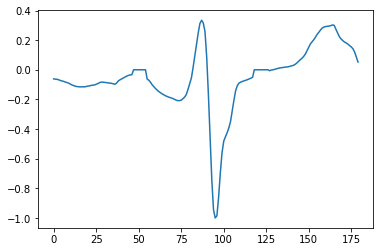

In [14]:

try:
  trainingData = np.load("ECG_DATA/trainingData.npy", allow_pickle=True)
except:
  trainingData = np.load("drive/My Drive/trainingData.npy", allow_pickle=True)
ecg = trainingData[0][0]
print(len(ecg))

plt.plot(ecg)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv1d(1, 45, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv1d(45, 90, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv1d(90, 180, 5)
        #self.conv4 = nn.Conv1d(180, 360, 4)
        #self.conv5 = nn.Conv1d(360, 720, 4)

        x = torch.randn(1,1,180).view(-1,1,180)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 180) #flattening.
        self.fc2 = nn.Linear(180, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2) # adjust shape of pooling?
        x = F.max_pool1d(F.relu(self.conv2(x)), 2) # x = F.max_pool1d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        #x = F.max_pool1d(F.relu(self.conv4(x)), 2)
        #x = F.max_pool1d(F.relu(self.conv5(x)), 2)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        #x = x.view(-1, 2294784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x


net = Net().to(device)
print(net)

NameError: ignored

In [16]:
import torch.optim as optim

#optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)

X = torch.Tensor([i[0] for i in trainingData])
y = torch.Tensor([i[1] for i in trainingData])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

6600


In [17]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

train_data = trainingData[:-val_size]

test_data = trainingData[-val_size:]

print(len(train_X), len(test_X))

59400 6600


In [18]:
 # insample accuracy & insample loss
 # outsample accuracy & outsample loss
import torch.nn as nn

def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss_function = nn.CrossEntropyLoss().to(device)
  loss = loss_function(outputs, torch.argmax(y, 1))
  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 180).to(device), y.to(device))
    return val_acc, val_loss

def net_info(net):
  params = []
  for layers, m in enumerate(net.modules()):
    params.append(int(''.join(filter(lambda x: x.isdigit(),str((str(m).split(',')[1]))))))

  return layers, params

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.26 tensor(1.3852, device='cuda:0', grad_fn=<NllLossBackward>)


In [19]:
import time

net = Net().apply(weight_reset).to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()#weight=1/torch.Tensor(list(Data_PreProcessing.dataCount.values())))

PATH = "/content/drive/My Drive/ECG_MODELS/"

layers, params = net_info(net)
MODEL_NAME = f"layers-{layers}_parms-{str(params)[1:-1].replace(', ', '_')}_model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time.

EPOCHS = 25
def train(net):
    BATCH_SIZE = 5000

    with open(PATH+"data/"+f"{MODEL_NAME}.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, len(train_X), BATCH_SIZE):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,180)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
              
print(MODEL_NAME)
train(net)
torch.save(net, PATH+"model_params/"+f'{MODEL_NAME}.pt')

model_data = open(PATH+"model_data/"+f"{MODEL_NAME}.txt", "w")
model_data.write(str(net))
model_data.write("/n")
model_data.write(str(optimizer))
model_data.write("/n")
model_data.write(str(loss_function))
model_data.close()

layers-5_parms-45_45_90_180_180_4_model-1579390189


  0%|          | 0/25 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [21]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner = RandomSearch(
    Net,
    objective = "val_accuracy",
    max_trials = 1,
    executions_per_trial = 1,
    #directory = PATH+"data/"+f"{MODEL_NAME}.log"
    )
tuner.search(x=train_X,
             y=train_y,
             epochs=2,
             batch_size=5000,
             validation_data=(test_X, test_y))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
TypeError: __init__() takes 1 positional argument but 2 were given


RuntimeError: ignored

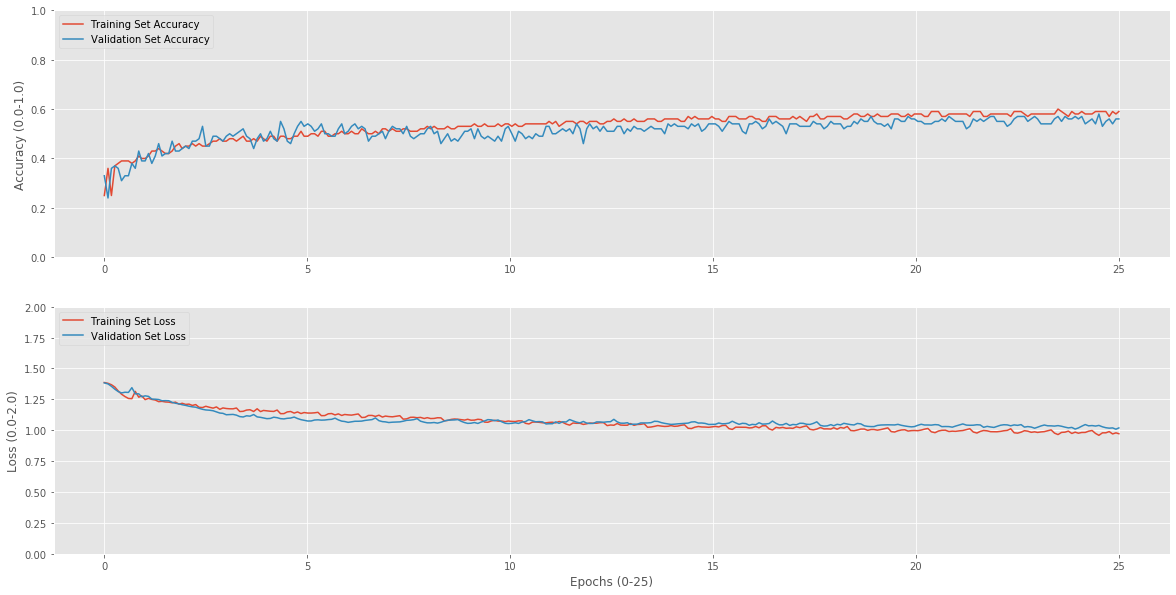

In [14]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

PATH = "/content/drive/My Drive/ECG_MODELS/"

def create_acc_loss_graph(model_name):
  contents = open(PATH+"data/"+f"{MODEL_NAME}.log", "r").read().split("\n")
  times = []
  accuracies = []
  losses = []
  mean_loss = []
  mean_acc = []
  val_accs = []
  val_losses = []

  contents = (c.split(",") for c in contents[:-1])
  for temp in list(contents):

    times.append(float(temp[0]))
    accuracies.append(float(temp[1]))
    losses.append(float(temp[2]))
    
    val_accs.append(float(temp[3]))
    val_losses.append(float(temp[4]))

  times = (np.asarray(times) - min(times))
  times = times/np.amax(times)
  times = times * EPOCHS
  fig = plt.figure(figsize=(20, 10))
  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

  ax1.set_ylim([0,1])
  ax1.set_ylabel('Accuracy (0.0-1.0)')
  ax1.plot(times, accuracies, label="Training Set Accuracy")
  ax1.plot(times, val_accs, label="Validation Set Accuracy")
  ax1.legend(loc=2)

  ax2.set_ylim([0,2])
  ax2.set_ylabel('Loss (0.0-2.0)')
  ax2.set_xlabel(f'Epochs (0-{EPOCHS})')
  ax2.plot(times, losses, label="Training Set Loss")
  ax2.plot(times, val_losses, label="Validation Set Loss")
  ax2.legend(loc=2)
  plt.savefig(PATH+"graphs/"+MODEL_NAME)
  plt.show()

create_acc_loss_graph(MODEL_NAME)